The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.8.0a0+52ea372'

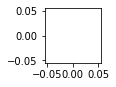

In [27]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# force plt on windows 10
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.plot()

import sys
sys.path.append("..")

import torch
import torch.nn as nn
import numpy as np
import aggets.ds.window as window
import aggets.ds.hyper_f_load as hfl
import aggets.ds.window as window
import aggets.train as train

## DISABLE THIS
import warnings
warnings.filterwarnings("ignore")
torch.__version__

In [6]:
%%time
import aggets.ds.hyper_f_load as hyper_f_load
data = hyper_f_load.load()

CPU times: user 788 ms, sys: 104 ms, total: 892 ms
Wall time: 889 ms


In [7]:
%%time
import aggets.ds.aggregate_nd as agg_nd
cols = ['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9', 'att10']
train_np = agg_nd.as_np(data['train'], cols, 'class')
val_np = agg_nd.as_np(data['val'], cols, 'class')
test_np = agg_nd.as_np(data['test'], cols, 'class')

window = agg_nd.window_generator(train_np, val_np, test_np, window_size=500, e=0.00001, hist_bins=20, hist_dim=1)

ranges -> [[-9.9999997e-06  1.0000089e+00]
 [-6.9999996e-06  1.0000089e+00]
 [-9.9999997e-06  1.0000100e+00]
 [-8.9999994e-06  1.0000100e+00]
 [-8.9999994e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000080e+00]
 [-8.9999994e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000089e+00]
 [-6.9999996e-06  1.0000070e+00]
 [-5.9999998e-06  1.0000089e+00]
 [-9.9999997e-06  1.0000100e+00]]
CPU times: user 40 ms, sys: 20 ms, total: 60 ms
Wall time: 71.2 ms


In [8]:
%%time
window.init_structures()

CPU times: user 1min 5s, sys: 11.8 s, total: 1min 16s                
Wall time: 1min 13s


In [9]:
%%time
import aggets.util as util
util.save(window, path='nwindow_02.bin')
# w = util.load(path='nwindow_01.bin') # 5 bins, 2 dim, 500ws
w = util.load(path='nwindow_02.bin') # 20 bins, 1 dim, 500ws

CPU times: user 108 ms, sys: 36 ms, total: 144 ms
Wall time: 143 ms


In [10]:
%%time
print('aggregates')
print(w.train_agges.shape)
print(w.val_agges.shape)
print(w.test_agges.shape)
print('models')
print(w.train_models.shape)
print(w.val_models.shape)
print(w.test_models.shape)
print('')
from aggets.model.aggregate import WindowConfig
dl = w.wrapped(WindowConfig(output_sequence_length=5, input_sequence_length=10),
              other={'source': 'agg', 'target': 'lr'}).train

print('sets')
def get_item_shape(item):
    if type(item) == list:
       return (item[0].shape, item[1].shape)
    return item.shape
[get_item_shape(l) for l in next(iter(dl))]


aggregates
torch.Size([1400, 5, 2, 10, 20])
torch.Size([400, 5, 2, 10, 20])
torch.Size([200, 5, 2, 10, 20])
models
torch.Size([1400, 5, 11])
torch.Size([400, 5, 11])
torch.Size([200, 5, 11])

sets
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.16 ms


[torch.Size([32, 10, 2, 10, 20]), torch.Size([32, 5, 11])]

In [11]:
!nvidia-smi

Mon May 17 17:09:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:02:00.0 Off |                  Off |
| 30%   42C    P0    28W / 250W |     26MiB / 32506MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# DMAJ: using Quadro GV100 32GB

device(type='cuda')

training model autoreg-lstm
saving model MTL=0.11135639257145367, MVL=0.16183446714135466
saving model MTL=0.05896873099188651, MVL=0.10186204729510136
saving model MTL=0.041964065463792895, MVL=0.0894139010886677
saving model MTL=0.03028026127904516, MVL=0.0850147118822473


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

CPU times: user 44.7 s, sys: 1.22 s, total: 45.9 s
Wall time: 46.3 s


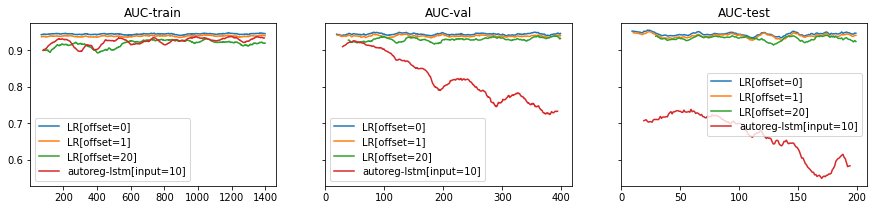

In [13]:
%%time
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST -> LR
hidden = 256

flatten = agg_m.Flatten(out_seq=5)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=400, num_layers=1, out_features=hidden) # DMAJ: needed to chenge it to 400
)
out = simple.mlp(features=hidden, num_layers=1, out_features=11)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'

train.train_window_models([lstm], w, patience=5, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='agg', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'agg', 'target':'lr'})

training model autoreg-lstm
saving model MTL=0.11620322565123233, MVL=0.24313585142620275
saving model MTL=0.08042628445108915, MVL=0.20622698547410184
saving model MTL=0.0612188337825685, MVL=0.09683297403523179
saving model MTL=0.03945155632317341, MVL=0.08870657154771149
saving model MTL=0.026230728039131734, MVL=0.08670414422379165


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

CPU times: user 1min 4s, sys: 1.06 s, total: 1min 5s
Wall time: 1min 5s


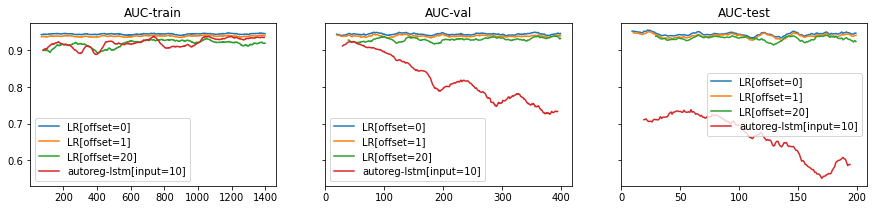

In [14]:
%%time
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST+LR -> LR
hidden = 256

inp = nn.Sequential(
    agg_m.FlatCat(),
    simple.mlp(features=411, num_layers=1, out_features=hidden) # DMAJ: needed to chenge it to 411
)
out = simple.mlp(features=hidden, num_layers=2, out_features=11)

lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='all', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'all', 'target':'lr'})

training model autoreg-lstm
saving model MTL=0.06273482941569539, MVL=0.03984664881327113
saving model MTL=0.027687975538706562, MVL=0.038410940375484405
saving model MTL=0.02620141461081461, MVL=0.030584921571807783
saving model MTL=0.02522038724786098, MVL=0.03008198396104281
saving model MTL=0.024367875111964317, MVL=0.028928333801812815
saving model MTL=0.023363585430069254, MVL=0.02889156747670447
saving model MTL=0.023137089881806745, MVL=0.02885561940244964
saving model MTL=0.02306526413170296, MVL=0.028783477964948435
saving model MTL=0.022980422789760684, MVL=0.028400777091012627
saving model MTL=0.022930693120584576, MVL=0.028070762906162464
saving model MTL=0.02280958856396172, MVL=0.027736805318320384
saving model MTL=0.022730637623697793, MVL=0.027392238653341276
saving model MTL=0.02266700276165107, MVL=0.027211718169636415
saving model MTL=0.02257698586364405, MVL=0.027186345186878423
saving model MTL=0.02257477887692528, MVL=0.02701607810669258
saving model MTL=0.022556

<Figure size 432x288 with 0 Axes>

CPU times: user 1min 18s, sys: 1.55 s, total: 1min 20s
Wall time: 1min 20s


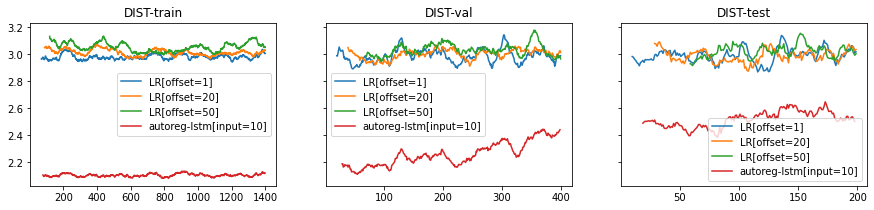

In [28]:
%%time
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST[0] -> HIST[0]
size = 200 #2250 // 2
hidden = 256
_out = 1

flatten = agg_m.Flatten(out_seq=_out)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=size, num_layers=1, out_features=hidden)
)
out = nn.Sequential(
    simple.mlp(features=hidden, num_layers=1, out_features=size),
    flatten.reverse()
)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=_out, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='agg[0]', target='agg[0]', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

CPU times: user 348 ms, sys: 12 ms, total: 360 ms
Wall time: 360 ms


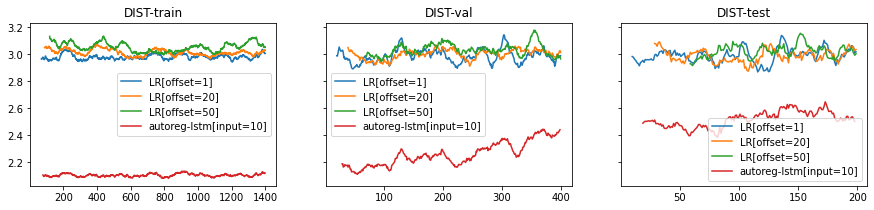

In [29]:
%%time
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

training model autoreg-lstm
saving model MTL=0.153976295638932, MVL=0.06260737990502452
saving model MTL=0.05667188859314, MVL=0.06187660753971241
saving model MTL=0.05654186702444466, MVL=0.06146084388992826
saving model MTL=0.05620201533540673, MVL=0.05952139962159219
saving model MTL=0.055893158232536884, MVL=0.058372580125683644
saving model MTL=0.05570994432024453, MVL=0.05827034234267767
saving model MTL=0.05558167941389828, MVL=0.05821729530809355
saving model MTL=0.05558576727063831, MVL=0.058138418637338235
saving model MTL=0.05550941573712257, MVL=0.058079553981784916
saving model MTL=0.055377948772879916, MVL=0.057944063219379206
saving model MTL=0.05485734206820847, MVL=0.05789477408665125
saving model MTL=0.05478798492102448, MVL=0.057711440825560054
saving model MTL=0.05458360936048381, MVL=0.05767598845919625
saving model MTL=0.054558829327515504, MVL=0.05743627696007979
saving model MTL=0.054500967247086925, MVL=0.057381051668866735
saving model MTL=0.05441823574381137,

<Figure size 432x288 with 0 Axes>

CPU times: user 1min 39s, sys: 2.4 s, total: 1min 41s
Wall time: 1min 41s


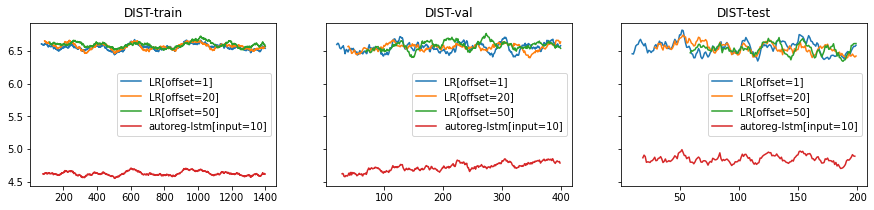

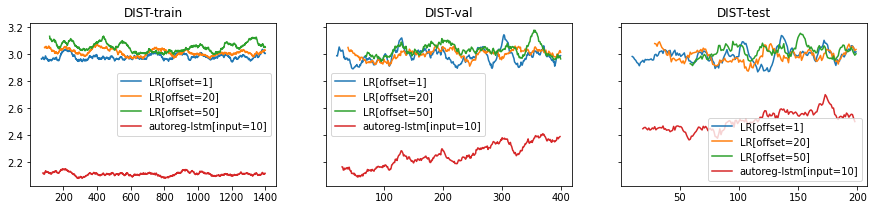

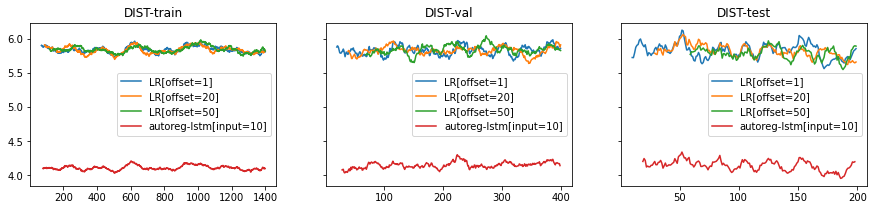

In [30]:
%%time
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST -> HIST
size = 400 # 2250 # DMAJ: needed to chenge it to 400
hidden = 256
_out = 1

flatten = agg_m.Flatten(out_seq=_out)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=size, num_layers=1, out_features=hidden)
)
out = nn.Sequential(
    simple.mlp(features=hidden, num_layers=1, out_features=size),
    flatten.reverse()
)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=_out, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='agg', target='agg', log=False)
# ------- p + d hist
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg', 'target': 'agg'})

# ------- p hist
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg', 'target': 'agg'}, select=lambda x: x[:, 0, 0])

# ------- d hist
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 1])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg', 'target': 'agg'}, select=lambda x: x[:, 0, 1])

training model autoreg-lstm
saving model MTL=0.09776495821121652, MVL=0.20443523394279792
saving model MTL=0.04396290873705242, MVL=0.08711857934955691
saving model MTL=0.022288827963757075, MVL=0.08159736128615551
saving model MTL=0.012437848245493278, MVL=0.08002943105873514
saving model MTL=0.012142722885454855, MVL=0.07973805338632865
saving model MTL=0.011994276702198015, MVL=0.07825631507840312
saving model MTL=0.011786748474884418, MVL=0.0776598860860848


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

CPU times: user 1min 48s, sys: 2.16 s, total: 1min 51s
Wall time: 1min 50s


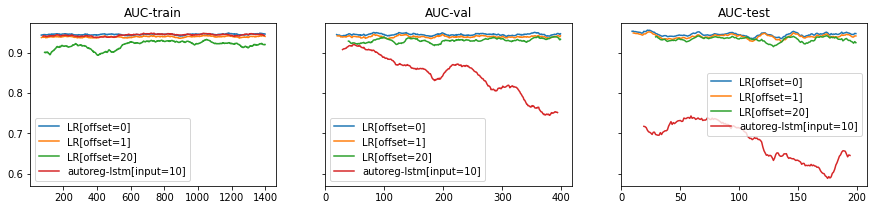

In [31]:
%%time
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# LR -> LR
size = 11
hidden = 16
inp = simple.mlp(features=size, num_layers=1, out_features=hidden)
out = simple.mlp(features=hidden, num_layers=1, out_features=size)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=16)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=20, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.001, 0.0001],
                          source='lr', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'lr', 'target':'lr'})

training model autoreg-lstm
saving model MTL=0.4711844624455916, MVL=0.3825603381532138
saving model MTL=0.14913040146641776, MVL=0.3215583147572689
saving model MTL=0.1386843906425008, MVL=0.3114587459407869
saving model MTL=0.13162468527571872, MVL=0.18248639267976166
saving model MTL=0.10068254613684952, MVL=0.1517099938431724
saving model MTL=0.0908435231433549, MVL=0.14716996325821172
saving model MTL=0.08375908499327275, MVL=0.14640848607313436
saving model MTL=0.07601878576732557, MVL=0.1452632981245635
saving model MTL=0.07182974867317654, MVL=0.14385962632835889
saving model MTL=0.07013698079443853, MVL=0.1432290905323185
saving model MTL=0.06906881255157497, MVL=0.1426718887247023
saving model MTL=0.06614385736644815, MVL=0.1409561552229475
saving model MTL=0.06510278715863141, MVL=0.13755704303745364


<Figure size 432x288 with 0 Axes>

CPU times: user 1min 47s, sys: 1.79 s, total: 1min 49s
Wall time: 1min 49s


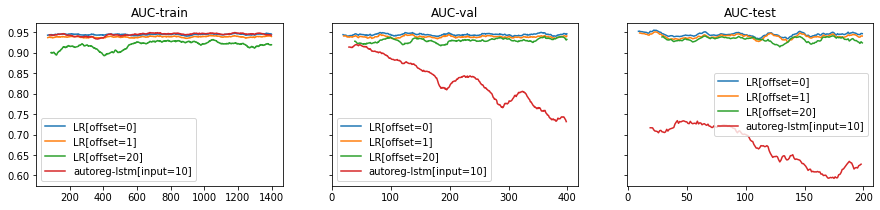

In [32]:
%%time
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST+LR -> HIST+LR
hidden = 512
flatcat = agg_m.FlatCat()

inp = nn.Sequential(
    flatcat,
    simple.mlp(features=411, num_layers=2, out_features=hidden) # DMAJ: needed to chenge it to 400
)
out = nn.Sequential(
    simple.mlp(features=hidden, num_layers=2, out_features=411), # DMAJ: needed to chenge it to 400
    flatcat.reverse()
)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=1, hidden=hidden, num_layers=2)

loss = nn.MSELoss()

def criterion(x, y):
    return loss(x[0], y[0]) + loss(x[1], y[1])
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='all', target='all', log=False,
                          criterion=criterion)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'all', 'target':'all'}, select=lambda x: x[1])

In [33]:
%%time
# import aggets.model.aggregate2 as agg_m
# import aggets.model.simple as simple
# import aggets.model.fourier as fourier
# # HIST[0] -> HIST[0]
# size = 20

# frr = fourier.HistogramLerner(size=size, hists=10, types=1, t_in=10)
# frr = fourier.FAdapter2(frr)
# frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# # -------
# frr.name = 'fourier'
# train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
#                           lrs=[0.001, 0.0001],
#                           source='agg[0]', target='agg[0]', log=False)

# # ------- p hist
# _, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
# w.plot_model_agg_dist(model=frr, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.29 µs


In [34]:
# ------- p hist
# _, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0]) # sample 0, hist_type 0
# w.plot_model_agg_dist(model=frr, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

In [35]:
%%time
# import aggets.model.aggregate2 as agg_m
# import aggets.model.simple as simple
# import aggets.model.fourier as fourier
# # HIST[0] -> HIST[0]
# size = 20

# frr = fourier.HistogramLerner(extra_dims=1, t_in=10)
# frr = fourier.FAdapter2(frr)
# frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# # -------
# frr.name = 'fourier'
# train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
#                           lrs=[0.001, 0.0001],
#                           source='agg[0]', target='agg[0]', log=False)

# # ------- p hist
# _, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
# w.plot_model_agg_dist(model=frr, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs


In [36]:
%%time
# import aggets.model.aggregate2 as agg_m
# import aggets.model.simple as simple
# import aggets.model.fourier as fourier
# # LR -> LR
# size = 11

# frr = fourier.HistogramLerner(extra_dims=0, t_in=10)
# frr = fourier.FAdapter2(frr)
# frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# # -------
# frr.name = 'fourier'
# train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
#                           lrs=[0.001, 0.0001],
#                           source='lr', target='lr', log=False)

# # ------- lr
# _, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# w.plot_lr(axs=axs)
# w.plot_model(frr, axs=axs, other={'source':'lr', 'target':'lr'})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.58 µs


In [37]:
%%time
# import torch.nn as nn

# class MultiLearner(nn.Module):
#     def __init__(self):
#         super(MultiLearner, self).__init__()
#         self.lr_learner = fourier.HistogramLerner(extra_dims=0, t_in=10)
#         self.agg_learner = fourier.HistogramLerner(extra_dims=2, t_in=10)
#         self.fc = simple.mlp(400 + 11, num_layers=2, out_features=11)

#     def forward(self, x):
#         ts, lr = x
#         lr = self.lr_learner(lr)
#         ts = self.agg_learner(ts)
#         lr = lr.flatten(start_dim=1)
#         ts = ts.flatten(start_dim=1)
#         return self.fc(torch.cat([ts, lr], dim=-1)).reshape(ts.shape[0], 1, 11)

    
# import aggets.model.aggregate2 as agg_m
# import aggets.model.simple as simple
# import aggets.model.fourier as fourier
# # HIST+LR -> LR
# frr = MultiLearner()
# frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# # -------
# frr.name = 'fourier'
# train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
#                           lrs=[0.001, 0.0001],
#                           source='all', target='lr', log=False)

# # ------- lr
# _, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# w.plot_lr(axs=axs)
# w.plot_model(frr, axs=axs, other={'source':'all', 'target':'lr'})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs


In [38]:
%%time
# class MultiLearner(nn.Module):
#     def __init__(self):
#         super(MultiLearner, self).__init__()
#         self.lr_learner = fourier.HistogramLerner(extra_dims=0, t_in=10)
#         self.agg_learner = fourier.HistogramLerner(extra_dims=2, t_in=10)
#         self.fc = simple.mlp(400 + 11, num_layers=2, out_features=11)

#     def forward(self, x):
#         ts, lr = x
#         lr = self.lr_learner(lr)
#         ts = self.agg_learner(ts)
#         lr = lr.flatten(start_dim=1)
#         ts = ts.flatten(start_dim=1)
#         return self.fc(torch.cat([ts, lr], dim=-1)).reshape(ts.shape[0], 1, 11)
# frr2 = MultiLearner()
# frr2.window_config = frr.window_config
# frr2.name = frr.name
# frr2.lr_learner = frr.lr_learner
# frr2.agg_learner = frr.agg_learner
# frr2.fc = frr.fc
# _, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# w.plot_lr(axs=axs)
# w.plot_model(frr2, axs=axs, other={'source':'all', 'target':'lr'})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.58 µs


training model DUMMY
saving model MTL=0.015392203242817057, MVL=0.015364996722487152
saving model MTL=0.015337321381810883, MVL=0.015358890819012141


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

CPU times: user 19.8 s, sys: 120 ms, total: 20 s
Wall time: 20 s


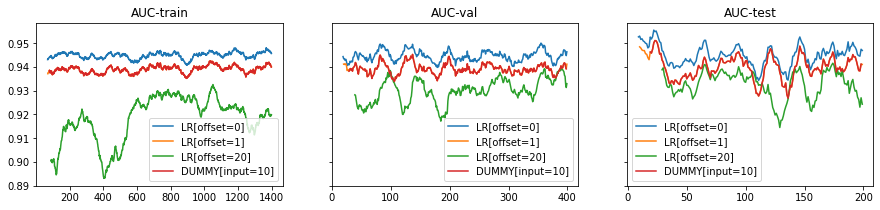

In [39]:
%%time
import aggets.model.aggregate as agg_m_old
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
import aggets.model.fourier as fourier
# HIST+LR -> LR
dmy = agg_m_old.DummyNet()
dmy.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# -------
dmy.name = 'DUMMY'
train.train_window_models([dmy], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
                          lrs=[0.001, 0.0001],
                          source='all', target='lr', log=False)

# ------- lr
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(dmy, axs=axs, other={'source':'all', 'target':'lr'})